# Введение

Кратко опишем наши данные: они представляют собой подборку демографической статистики с портала открытых данных Правительства Москвы + данные о численности населении Москвы от Росстата.
- ID - технический номер строки
- Year - год наблюдений
- Month - месяц наблюдений
- StateRegistrationOfBirth - число зарегистрированных рождений
- NumberOfBirthCertificatesForBoys - число выданных свидетельств о рождении мальчиков
- NumberOfBirthCertificatesForGirls - число выданных свидетельств о рождении девочек
- StateRegistrationOfDeath - число зарегистрированных смертей
- StateRegistrationOfMarriage - число зарегистрированных браков
- StateRegistrationOfDivorce - число зарегистрированных разводов
- StateRegistrationOfPaternityExamination - число зарегистрированных тестов на отцовство
- StateRegistrationOfAdoption - число зарегистрированных усыновлений/удочерений
- StateRegistrationOfNameChange - число зарегистрированных смен имени/фамилии
- TotalPopulationThisYear - общая численность населения Москвы по годам

# Предобработка данных

Импортируем необходимые библиотеки, считываем сам файл и смотрим на получившийся датасет.

In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv('moscow_stats.csv')
df.head()

,ID,Year,Month,StateRegistrationOfBirth,NumberOfBirthCertificatesForBoys,NumberOfBirthCertificatesForGirls,StateRegistrationOfDeath,StateRegistrationOfMarriage,StateRegistrationOfDivorce,StateRegistrationOfPaternityExamination,StateRegistrationOfAdoption,StateRegistrationOfNameChange,TotalPopulationThisYear
0,1,2010,January,9206,4785,4421,10430,4997,3302,1241,95,491,11503501
1,2,2010,February,9060,4656,4404,9573,4873,2937,1326,97,639,11503501
2,3,2010,March,10934,5630,5304,10528,3642,4361,1644,147,717,11503501
3,4,2010,April,10140,5278,4862,9501,9698,3943,1530,128,642,11503501
4,5,2010,May,9457,4825,4632,9482,3726,3554,1397,96,492,11503501


Всё считалось нормально. Теперь посмотрим, везде ли стоят подходящие типы данных.

In [2]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124 entries, 0 to 123
Data columns (total 13 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   ID                                       124 non-null    int64 
 1   Year                                     124 non-null    int64 
 2   Month                                    124 non-null    object
 3   StateRegistrationOfBirth                 124 non-null    int64 
 4   NumberOfBirthCertificatesForBoys         124 non-null    int64 
 5   NumberOfBirthCertificatesForGirls        124 non-null    int64 
 6   StateRegistrationOfDeath                 124 non-null    int64 
 7   StateRegistrationOfMarriage              124 non-null    int64 
 8   StateRegistrationOfDivorce               124 non-null    int64 
 9   StateRegistrationOfPaternityExamination  124 non-null    int64 
 10  StateRegistrationOfAdoption              124 non-null    int64

Отлично, ничего поправлять не надо. Теперь проверим каждую колонку на пропуски.

In [3]:
df.isnull().sum()

ID                                         0
Year                                       0
Month                                      0
StateRegistrationOfBirth                   0
NumberOfBirthCertificatesForBoys           0
NumberOfBirthCertificatesForGirls          0
StateRegistrationOfDeath                   0
StateRegistrationOfMarriage                0
StateRegistrationOfDivorce                 0
StateRegistrationOfPaternityExamination    0
StateRegistrationOfAdoption                0
StateRegistrationOfNameChange              0
TotalPopulationThisYear                    0
dtype: int64

И даже пропусков нет - какой замечательный датасет! А что там с выбросами?

Если бы у нас были пропуски, например, в StateRegistrationOfBirth (общее число рождений), то мы бы поступили таким образом: заполнили бы их техническим значением с помощью кода df.fillna(0, inplace=True)

In [4]:
# транспонируем таблицу, чтобы потом можно было создать новый столец с интерквартильным размахом
df_stat = df[['StateRegistrationOfBirth', 'NumberOfBirthCertificatesForBoys', 'NumberOfBirthCertificatesForGirls', 'StateRegistrationOfDeath', 'StateRegistrationOfMarriage', 'StateRegistrationOfDivorce', 'StateRegistrationOfPaternityExamination', 'StateRegistrationOfAdoption', 'StateRegistrationOfNameChange', 'TotalPopulationThisYear']].describe().T

# столбец с интерквартильным размахом
df_stat['iqr'] = df_stat['75%'] - df_stat['25%']

# определяем нижнюю и верхнюю границу допустимых значений
df_stat['lower_bound'] = df_stat['25%'] - 1.5 * df_stat['iqr']
df_stat['upper_bound'] = df_stat['75%'] + 1.5 * df_stat['iqr']

# создаём дополнительный признак, который показывает, есть ли выбросы по каждой из границ
df_stat['any_outlier_min'] = np.where(df_stat['lower_bound'] - df_stat['min'] > 0, 'yes', 'no')
df_stat['any_outlier_max'] = np.where(df_stat['max'] - df_stat['upper_bound'] > 0, 'yes', 'no')

df_stat

,count,mean,std,min,25%,50%,75%,max,iqr,lower_bound,upper_bound,any_outlier_min,any_outlier_max
StateRegistrationOfBirth,124.0,1.117704e+04,1203.358555,3959.0,10555.25,11233.5,11825.50,13620.0,1270.25,8.649875e+03,1.373088e+04,yes,no
NumberOfBirthCertificatesForBoys,124.0,5.765685e+03,626.414424,2042.0,5458.00,5820.5,6115.25,7082.0,657.25,4.472125e+03,7.101125e+03,yes,no
NumberOfBirthCertificatesForGirls,124.0,5.411355e+03,582.151814,1917.0,5119.25,5430.5,5748.75,6646.0,629.50,4.175000e+03,6.693000e+03,yes,no
StateRegistrationOfDeath,124.0,9.992145e+03,903.146025,8520.0,9463.50,9831.0,10264.25,15016.0,800.75,8.262375e+03,1.146538e+04,no,yes
StateRegistrationOfMarriage,124.0,7.570089e+03,2907.430570,3365.0,5004.50,6749.5,10181.50,13915.0,5177.00,-2.761000e+03,1.794700e+04,no,no
StateRegistrationOfDivorce,124.0,3.713774e+03,441.041005,1424.0,3516.25,3778.5,3986.00,4474.0,469.75,2.811625e+03,4.690625e+03,yes,no
StateRegistrationOfPaternityExamination,124.0,1.459500e+03,184.422698,323.0,1359.50,1488.5,1573.25,1771.0,213.75,1.038875e+03,1.893875e+03,yes,no
StateRegistrationOfAdoption,124.0,8.422581e+01,23.579597,7.0,69.75,84.5,97.00,149.0,27.25,2.887500e+01,1.378750e+02,yes,yes
StateRegistrationOfNameChange,124.0,7.486290e+02,144.643575,54.0,674.25,762.0,838.50,1078.0,164.25,4.278750e+02,1.084875e+03,yes,no
TotalPopulationThisYear,124.0,1.214330e+07,341892.613944,11503501.0,11856578.00,12197596.0,12380664.00,12678079.0,524086.00,1.107045e+07,1.316679e+07,no,no


Так, выбросов много, где-то они даже есть с обеих сторон. Для простоты восприятия давайте их визуализируем

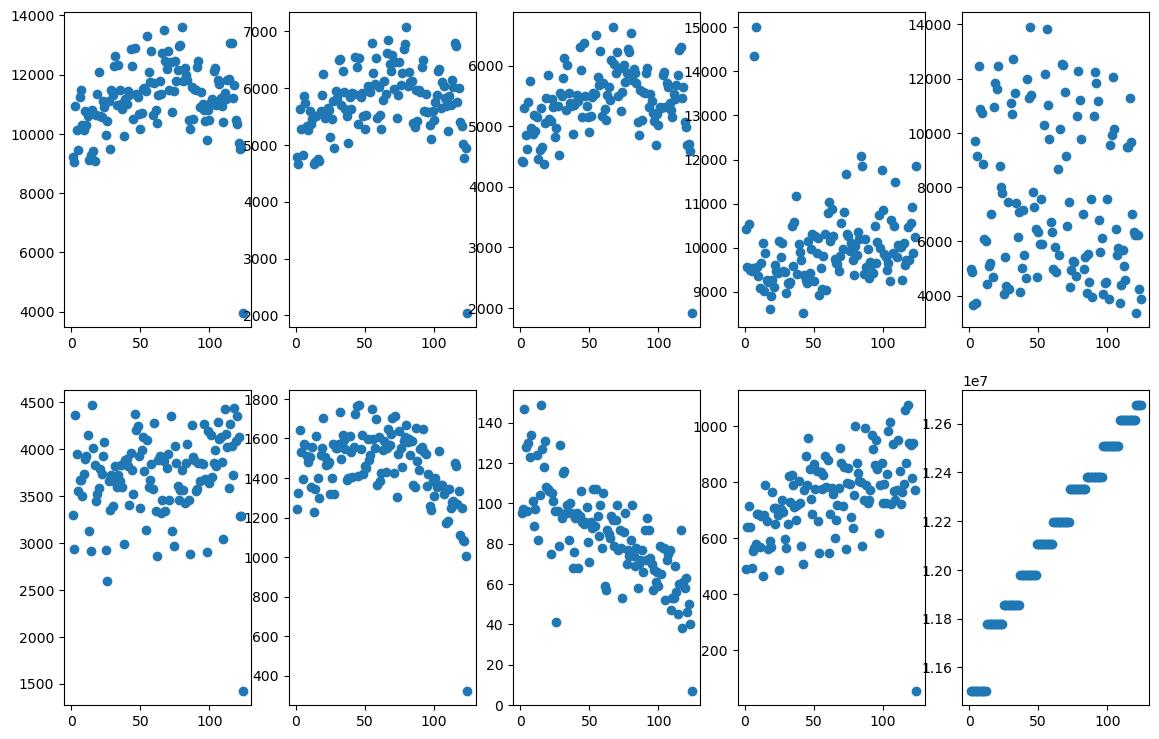

In [5]:
import matplotlib.pyplot as plt 
%matplotlib inline

fig, ax = plt.subplots(2, 5, figsize=(14,9))
ax[0][0].scatter(df.ID, df.StateRegistrationOfBirth)
ax[0][1].scatter(df.ID, df.NumberOfBirthCertificatesForBoys)
ax[0][2].scatter(df.ID, df.NumberOfBirthCertificatesForGirls)
ax[0][3].scatter(df.ID, df.StateRegistrationOfDeath)
ax[0][4].scatter(df.ID, df.StateRegistrationOfMarriage)
ax[1][0].scatter(df.ID, df.StateRegistrationOfDivorce)
ax[1][1].scatter(df.ID, df.StateRegistrationOfPaternityExamination)
ax[1][2].scatter(df.ID, df.StateRegistrationOfAdoption)
ax[1][3].scatter(df.ID, df.StateRegistrationOfNameChange)
ax[1][4].scatter(df.ID, df.TotalPopulationThisYear);

Посмотрели - и хватит, давайте удалим выбросы, чтобы они не портили статистику.

Из того, что мы видим, выбросы надо удалять везде, кроме StateRegistrationOfMarriage и TotalPopulationThisYear. Причём в StateRegistrationOfDeath надо удалять выбросы сверху, в StateRegistrationOfAdoption - и сверху, и снизу, а во всех остальных - снизу.

In [6]:
df.drop(df[df.StateRegistrationOfBirth < 8.649875e+03].index, inplace=True)
df.drop(df[df.NumberOfBirthCertificatesForBoys < 4.472125e+03].index, inplace=True) 
df.drop(df[df.NumberOfBirthCertificatesForGirls < 4.175000e+03].index, inplace=True)
df.drop(df[df.StateRegistrationOfDeath > 1.146538e+04].index, inplace=True)
df.drop(df[df.StateRegistrationOfDivorce < 2.811625e+03].index, inplace=True)
df.drop(df[df.StateRegistrationOfPaternityExamination < 1.038875e+03].index, inplace=True)
df.drop(df[df.StateRegistrationOfAdoption < 2.887500e+01].index, inplace=True)
df.drop(df[df.StateRegistrationOfAdoption > 1.378750e+02].index, inplace=True)
df.drop(df[df.StateRegistrationOfNameChange < 4.278750e+02].index, inplace=True)

# Описательные статистики

При помощи метода describe мы смотрим описательные статистики для количественных переменных. 

In [7]:
df.describe()

,ID,Year,StateRegistrationOfBirth,NumberOfBirthCertificatesForBoys,NumberOfBirthCertificatesForGirls,StateRegistrationOfDeath,StateRegistrationOfMarriage,StateRegistrationOfDivorce,StateRegistrationOfPaternityExamination,StateRegistrationOfAdoption,StateRegistrationOfNameChange,TotalPopulationThisYear
count,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,1.120000e+02
mean,62.446429,2014.651786,11283.187500,5821.678571,5461.508929,9808.285714,7774.678571,3736.526786,1474.205357,84.607143,759.901786,1.214381e+07
std,34.703335,2.887406,1035.966525,542.031584,499.682818,541.404204,2845.833845,372.152152,148.392961,19.905795,131.698739,3.271518e+05
min,1.000000,2010.000000,9060.000000,4656.000000,4383.000000,8520.000000,3365.000000,2860.000000,1082.000000,38.000000,464.000000,1.150350e+07
25%,33.750000,2012.000000,10606.000000,5480.000000,5150.000000,9430.500000,5273.250000,3553.500000,1362.250000,70.750000,682.500000,1.185658e+07
50%,61.500000,2015.000000,11321.500000,5866.000000,5466.500000,9737.000000,7063.500000,3784.500000,1494.500000,86.500000,767.000000,1.219760e+07
75%,92.250000,2017.000000,12017.250000,6162.750000,5817.750000,10148.500000,10360.500000,3965.000000,1573.250000,96.250000,842.250000,1.238066e+07
max,122.000000,2020.000000,13620.000000,7082.000000,6646.000000,11184.000000,13915.000000,4438.000000,1771.000000,131.000000,1078.000000,1.267808e+07


1. Можно отметить интересный факт, что изначально мальчиков рождается больше, чем девочек. В среднем это 5821 мальчик на 5461 девочку, но при этом с течением жизни это соотношение меняется в пользу девочек. 

2. Кроме того, интересным представляется факт, что количество заключенных браков в среднем чуть больше, чем в 2 раза превышает число разводов. Это дает нам надежду на то, что любовь победит 🫶🏻

3. Средняя смертность ниже, чем средняя рождаемость, что говорит о положительном естественном приросте населения.

In [8]:
df.groupby('Month')['StateRegistrationOfBirth'].sum().sort_values(ascending=False)

Month
October      119257
June         116221
July         113736
August       112904
November     111491
September    111067
May          110921
April        107259
December     100285
February     100103
January       80740
March         79733
Name: StateRegistrationOfBirth, dtype: int64

Самый большой месяц по рождаемости – октябрь. Мы проанализировали, сделали необходимые расчеты и пришли к выводу, что потенциальный месяц зачатия – февраль. Мы выделили 3 причины для такого явления:

1. Все хотят детей Весов 
2. Февраль – время холодов в Москве, когда они уже всем надоели и все насмотрелись на снег, поэтому предпочитают сидеть дома и согреваться теплом друг друга
3. Исполнение супружеского долга является популярным подарком на 23 февраля

# Построение модели машинного обучения

Мы решили построить модель линейной регрессии, чтобы проверить влияние количества заключенных браков на число рожденных детей. Таргетом будет являться StateRegistrationOfBirth, а признаком будет переменная StateRegistrationOfMarriage. 

In [9]:
import statsmodels.formula.api as smf

# создаём модель по заданной формуле и обучаем ее на data при помощи метода .fit()
lm = smf.ols(formula='StateRegistrationOfBirth ~ StateRegistrationOfMarriage', data=df).fit()

# выведем полученные коэффициенты модели
lm.params

Intercept                      9802.308981
StateRegistrationOfMarriage       0.190475
dtype: float64

In [ ]:
#итоговая формула для линейной регрессии 

StateRegistrationOfBirth = 9802.308981 + 0.190475*StateRegistrationOfMarriage

Посмотрим на p-value признака, чтобы определить, нужно ли нам его учитывать

In [10]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     StateRegistrationOfBirth   R-squared:                       0.274
Model:                                  OLS   Adj. R-squared:                  0.267
Method:                       Least Squares   F-statistic:                     41.47
Date:                      Thu, 14 Dec 2023   Prob (F-statistic):           3.24e-09
Time:                              13:02:13   Log-Likelihood:                -918.13
No. Observations:                       112   AIC:                             1840.
Df Residuals:                           110   BIC:                             1846.
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                    9802.3090    244.755     40.050      0.000    9317.263    1.03e+04
StateRegistrationOfMarriage     0.1905      0.030      6.440      0.000       0.132       0.249
==============================================================================
Omnibus:                        6.518   Durbin-Watson:                   1.317
Prob(Omnibus):                  0.038   Jarque-Bera (JB):                3.404
Skew:                          -0.189   Prob(JB):                        0.182
Kurtosis:                       2.234   Cond. No.                     2.42e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.42e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

P-value 0, поэтому признак является репрезентативным, мы можем делать прогнозы, основываясь на нем.

### Интерпретация коэффициентов модели

Как мы интерпретируем StateRegistrationOfMarriage коэффициент (𝛽1)?

Дополнительные 1000 браков увеличивают число зарегистрированных рождений детей на 190.

Обратим внимание, что если бы увеличение браков приводило к снижению рождаемости, то  𝛽1 был бы отрицательным.

In [11]:
#Сделаем прогноз 

k = 9802.308981 + 0.190475*69
print(f'При увеличении числа браков на 69 число рождений становится равным {round(k)}')

При увеличении числа браков на 69 число рождений становится равным 9815


## Построение модели множественной регрессии

Мы решили построить модель множественной линейной регрессии, чтобы посмотреть влияние количества разводов и количества усыновлений на количество рожденных детей. Таргетом будет являться StateRegistrationOfBirth, а признаками будут являться переменные StateRegistrationOfDivorce, StateRegistrationOfAdoption. 

In [15]:
# создаём модель по заданной формуле и обучаем ее на data при помощи метода .fit()
lm = smf.ols(formula='StateRegistrationOfBirth ~ StateRegistrationOfDivorce + StateRegistrationOfAdoption', data=df).fit()

# выведем полученные коэффициенты модели
lm.params

Intercept                      7550.006123
StateRegistrationOfDivorce        0.981285
StateRegistrationOfAdoption       0.786954
dtype: float64

In [ ]:
#формула множественной линейной регрессии

StateRegistrationOfBirth = 7550.006123 + 0.981285*StateRegistrationOfDivorce + 0.786954*StateRegistrationOfAdoption

In [16]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     StateRegistrationOfBirth   R-squared:                       0.125
Model:                                  OLS   Adj. R-squared:                  0.109
Method:                       Least Squares   F-statistic:                     7.794
Date:                      Thu, 14 Dec 2023   Prob (F-statistic):           0.000686
Time:                              13:07:44   Log-Likelihood:                -928.56
No. Observations:                       112   AIC:                             1863.
Df Residuals:                           109   BIC:                             1871.
Df Model:                                 2                                         
Covariance Type:                  nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                    7550.0061    996.235      7.579      0.000    5575.500    9524.512
StateRegistrationOfDivorce      0.9813      0.250      3.928      0.000       0.486       1.476
StateRegistrationOfAdoption     0.7870      4.671      0.168      0.867      -8.470      10.044
==============================================================================
Omnibus:                        0.707   Durbin-Watson:                   0.580
Prob(Omnibus):                  0.702   Jarque-Bera (JB):                0.795
Skew:                           0.066   Prob(JB):                        0.672
Kurtosis:                       2.609   Cond. No.                     4.05e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.05e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Смотрим на p-value признаков. В случае с разводами p-value 0, поэтому мы можем использовать этот признак для прогнозирования, а количество усыновлений не является таковым, потому что у него p-value высокий, соответственно, мы не можем использовать этот признак, потому что высока вероятность ошибки.

R-квадрат в данной модели обучения меньше, чем в предыдущей модели линейной регресии, значит, эта модель менее репрезентативна, чем предыдущая.

In [23]:
#Сделаем прогноз по итоговой формуле

g = 7550.006123 + 0.981285*100 + 0.786954*100

Интерпретация результатов такова, что в настоящее время снижается ценность брака в рамках рождения детей, потому что увеличение числа разводов на 100 приводит к увеличению числа рождений на 98 ребенка.

# the best ever визуализация

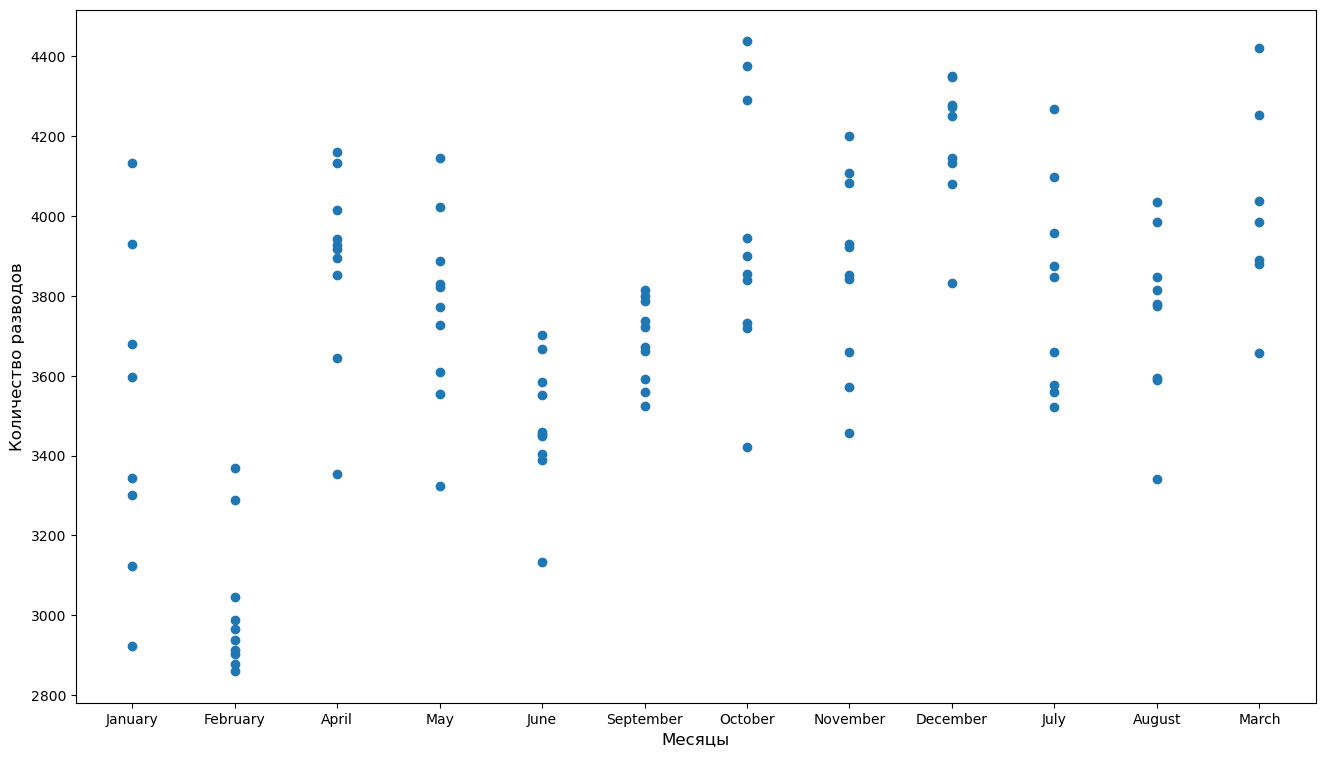

In [26]:
fig, ax = plt.subplots(figsize=(16,9))
ax.scatter(df['Month'], df['StateRegistrationOfDivorce'])
ax.set_xlabel('Месяцы', fontsize=12)
ax.set_ylabel('Количество разводов', fontsize=12);

**Вывод**: Если смотреть на график, то зависимости между месяцем и числом разводов нет

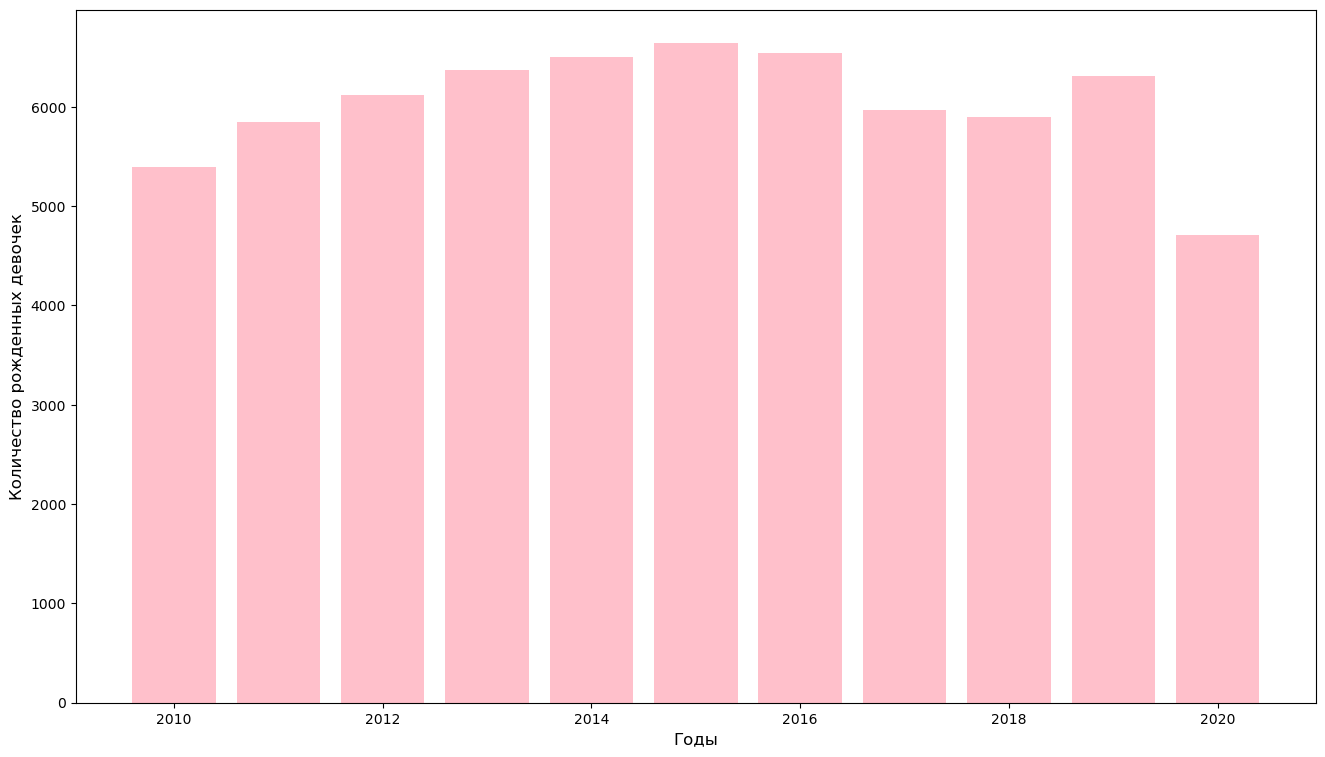

In [29]:
fig, ax = plt.subplots(figsize=(16,9))
plt.bar(df['Year'], df['NumberOfBirthCertificatesForGirls'], color = 'pink')
ax.set_xlabel('Годы', fontsize=12)
ax.set_ylabel('Количество рожденных девочек', fontsize=12);

**Вывод**: Начиная с 2010 года и до 2015 наблюдался рост рождаемости девочек, а после начался спад. Некое улучшение ситуации произошло в 2019 году. В 2020 году учитывались только январь и февраль, но уровень рождаемости девочек уже оказался равен примерно 3/4 от общей рождаемости девочек за 12 месяцев 2019 года. 

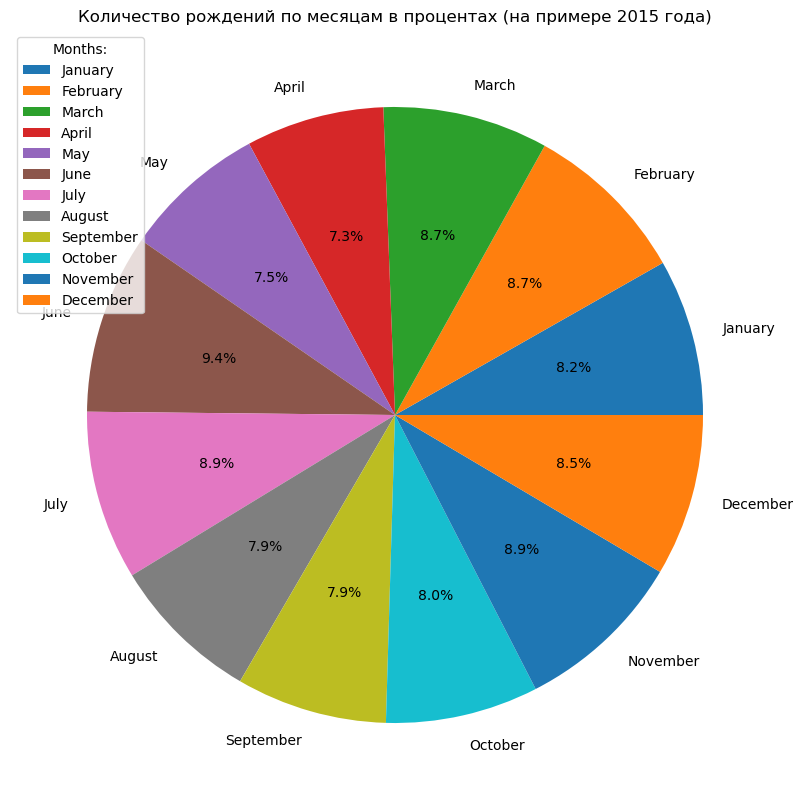

In [30]:
df2015 = df[df['Year'] == 2015]
mylabels = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
y = df2015.groupby('Month')['StateRegistrationOfBirth'].sum()

fig, ax = plt.subplots(figsize=(10,10))
plt.pie(y, labels=mylabels, autopct ='%1.1f%%')
plt.legend(title='Months:')
plt.title('Количество рождений по месяцам в процентах (на примере 2015 года)')
plt.show()

**Вывод**: больше всего девочек рождается в июне. Второе место делят ноябрь и июль.